In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import Accuracy,FalseNegatives, FalsePositives
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Case 3.
Your name Oskar Rönnberg and team number 15<br>
Last edited: 19.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>
<br>I have multiple versions of case 3 with different setups. Case 3 V1 contains explained steps taken in detail, I'll spare you from them from the rest of the versions, they will of course contain commentary from graphs and changes made to them compared to other versions.

# Data
The data used in this project concerns medical drug reviews from Drugs.com, the task was to use the methods of text processing and to experiment with recurrent and/or convolutional (1D) neural networks to create a classifier for a collection of patient drug reviews.<br>Data comes in two csv files drugsComTrain_raw and drugsComTest_raw.


In [3]:
dataTrain = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTrain_raw.csv')
dataTest = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTest_raw.csv')
dataTrain.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


# Preprocessing
The assignmet was: Can you predict the rating of the drug based on the review?, we will need columns 'review' and 'rating' from dataframes.<br><br>
First we want to tokenize the text data so its split to words. Then fit_on_texts to update internal vocabulary based on a list of text samples. After that make the text to sequences and pad the sequences with maxlen of 200 so, they are all 200 units long.

In [15]:
# Tokenize the text
samples = dataTrain['review']
samplesTest = dataTest['review']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)
tokenizer.fit_on_texts(samplesTest)
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)
sequencesTest = tokenizer.texts_to_sequences(samplesTest)

word_index = tokenizer.word_index

print('Found %s unique tokens in train data.' % len(word_index))

#pad sequences
Data = pad_sequences(sequences, maxlen=200)
DataTest = pad_sequences(sequencesTest, maxlen=200)

Found 55245 unique tokens in train data.


Make labels to training and testing data. In the case 3 version only three categories are used. 8-10 = good, 4-7 = moderate and 1-3 bad

In [17]:
# Create 3 categories for training
# label = 2, when rating = 8-10
# label = 1, when rating = 4-7
# label = 0, when rating = 1-3
Labels = dataTrain['rating'].values
for i in range(len(Labels)):
    x = Labels[i]
    if x > 7:
        Labels[i] = 2
    elif x >= 4:
        Labels[i] = 1   
    else:
        Labels[i] = 0
# Create 3 categories for testing
# label = 2, when rating = 8-10
# label = 1, when rating = 4-7
# label = 0, when rating = 1-3
LabelsTest = dataTest['rating'].values
for i in range(len(LabelsTest)):
    x = LabelsTest[i]
    if x > 7:
        LabelsTest[i] = 2
    elif x >= 4:
        LabelsTest[i] = 1   
    else:
        LabelsTest[i] = 0        

Labels and LabelsTest conversion from a class vector to a binary class matrix for categoriseing.

In [18]:
Labels = to_categorical(np.asarray(Labels))
LabelsTest = to_categorical(np.asarray(LabelsTest))

In [19]:
print('Shape of train data tensor:', Data.shape)
print('Shape of train label tensor:', Labels.shape)
print('Shape of test data tensor:', DataTest.shape)
print('Shape of test label tensor:', LabelsTest.shape)
print(Labels)

Shape of train data tensor: (161297, 200)
Shape of train label tensor: (161297, 3)
Shape of test data tensor: (53766, 200)
Shape of test label tensor: (53766, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


30% percent of Data with go for validation. Store values to indices from np.arange(Data.shape[0]), shuffle Data and Labels and get the amount of validation samples. Split the Data to train data, train labels, validation data and validation labels. 

In [20]:
validation_split = 0.3
# split the data into a training set and a validation set
indices = np.arange(Data.shape[0])
np.random.shuffle(indices)
Data = Data[indices]
Labels = Labels[indices]
#Amount of validation samples
nb_validation_samples = int(validation_split * Data.shape[0])

x_train = Data[:-nb_validation_samples]
y_train = Labels[:-nb_validation_samples]
x_validation = Data[-nb_validation_samples:]
y_validation = Labels[-nb_validation_samples:]

# The model
For model I decided to use 1D tensors, because I am familiar with 2D tensors already from the previous assignment and I thought that 1D convolution layers could be efficient at recognizing local patterns in a sequence. I also decided to word embeddings in this model I use word embedding with max limit of 5000 words, dimension of 100, input length of 200 since we already padded the data to 200 and make the word embedding trainable.

The model has three Conv1D layers to take 1x4 vector from inputs. Two MaxPooling1D layers to halven the amount of data and one GlobalMaxPooling1D to vectorize to from (128). One Dense layer in form of (128) and then final layer "prediction" with 3 classes and softmax activation function. Since this is a multichoise class prediction, the loss function needs to be categorical_crossentropy. Optimizer rmsprop will work well in this example since its fast and I have gotten good results with it earlier. Metrics "accuracy" will be enough for this assignment. The model summary is below.

In [21]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(3, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048 

In [22]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_validation, y_validation))

Train on 112908 samples, validate on 48389 samples
Epoch 1/10
112908/112908 [==============================] - 82s 730us/sample - loss: 0.7093 - acc: 0.7033 - val_loss: 0.6262 - val_acc: 0.7392
Epoch 2/10
112908/112908 [==============================] - 75s 663us/sample - loss: 0.5727 - acc: 0.7632 - val_loss: 0.7460 - val_acc: 0.7014
Epoch 3/10
112908/112908 [==============================] - 74s 655us/sample - loss: 0.4803 - acc: 0.8061 - val_loss: 0.5555 - val_acc: 0.7827
Epoch 4/10
112908/112908 [==============================] - 74s 653us/sample - loss: 0.3926 - acc: 0.8459 - val_loss: 0.5829 - val_acc: 0.7715
Epoch 5/10
112908/112908 [==============================] - 72s 639us/sample - loss: 0.3051 - acc: 0.8860 - val_loss: 0.6122 - val_acc: 0.7634
Epoch 6/10
112908/112908 [==============================] - 79s 698us/sample - loss: 0.2308 - acc: 0.9158 - val_loss: 0.6384 - val_acc: 0.8234
Epoch 7/10
112908/112908 [==============================] - 78s 687us/sample - loss: 0.1805

Lets plot the results and see what kind of results we got

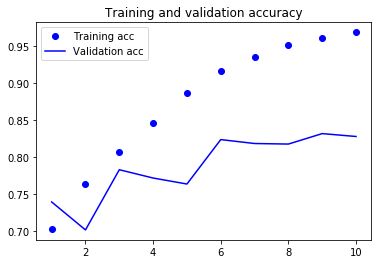

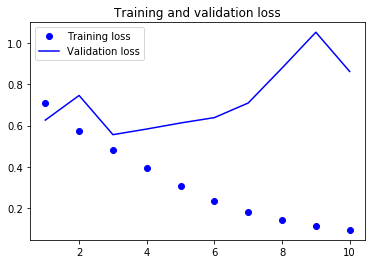

<Figure size 432x288 with 0 Axes>

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

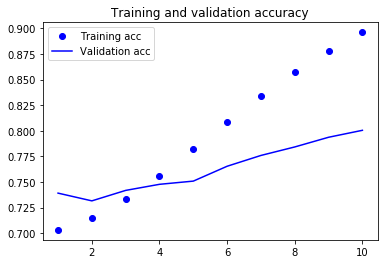

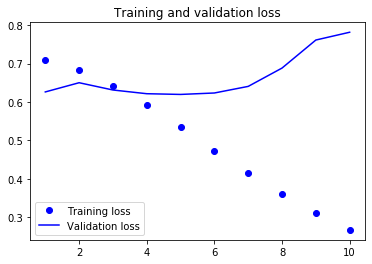

<Figure size 432x288 with 0 Axes>

In [24]:
epochs = range(1, len(acc) + 1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

The model starts to overfit right from the epoch 3. We could use dropout, L1 or L2 regularization within the model layers but lets see where we can go without them. 

Below are some statistics:

In [35]:
# Find the predicted values for the test set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

In [36]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 9423  1489  1023]
 [ 1088  5379  1792]
 [ 1327  2711 29534]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     11838
           1       0.65      0.56      0.60      9579
           2       0.88      0.91      0.90     32349

    accuracy                           0.82     53766
   macro avg       0.77      0.76      0.76     53766
weighted avg       0.82      0.82      0.82     53766



In [37]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.680
Cohen's kappa (quadratic) = 0.775


As can be seen from the graphs ontop, model clearly overfits with 10 epochs of training but it's Cohen's kappa values and classification values are quite nice to look at 0.82 accuracy etc.<br>
Cohen's kappa is a statistic that is used to measure inter-rater reliability (the degree of agreement among raters) for qualitative (categorical) items. Cohen's kappa tells us how much homogeneity or consensus exists in the ratings given by various judges. <br>A weighted Kappa is a metric which is used to calculate the amount of similarity between predictions and actuals. A perfect score of 1.0 is granted when both the predictions and actuals are the same. The aim is to get as close to 1 as possible.
<br><br>Cohen's kappa (linear) : <br><br> Formula for the linearly weighted Kappa:<br><br> κw  = (Po –Pe)/(1-Pe) <br><br>in which Po is the proportion weighted observed agreement, and Pe is the proportion weighted chance agreement.
<br><br>Cohen's kappa (quadratic) : <br><br> Same but with different weights

The results are quite good, lets try to lessen the overfitting by decreasing the amount of epochs to 3, everything else is remains the same.

In [38]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(3, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [39]:
history = model.fit(Data, Labels,
          batch_size=128,
          epochs=3,
          validation_data=None)

Train on 161297 samples
Epoch 1/3
161297/161297 [==============================] - 105s 652us/sample - loss: 0.6808 - acc: 0.7166
Epoch 2/3
161297/161297 [==============================] - 103s 640us/sample - loss: 0.5342 - acc: 0.7819
Epoch 3/3
161297/161297 [==============================] - 100s 622us/sample - loss: 0.4479 - acc: 0.8209


In [40]:
# Find the predicted values for the test set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 8414  1276   437]
 [ 2043  4705  1685]
 [ 1381  3598 30227]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.77     11838
           1       0.56      0.49      0.52      9579
           2       0.86      0.93      0.89     32349

    accuracy                           0.81     53766
   macro avg       0.75      0.71      0.73     53766
weighted avg       0.80      0.81      0.80     53766



In [41]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.639
Cohen's kappa (quadratic) = 0.774


Accuracy went down to 0.81 and Cohen's kappa linear went down from 0.680 to 0.639, a 0.041 difference. Since overfitting is bad and should be avoided when possible the latter result is better. Lets try now what kind of result we can get with a pretrained word embeddings from glove.6B.200d in Case 3 Three rating categories glove.6B.200d V2